# Virgo: exploratory data analysis

## Libraries

In [34]:
import yfinance as yf
import pandas as pd
import numpy as np

In [35]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [36]:
import datetime
from dateutil.relativedelta import relativedelta

## Transfomations

visualising stock data

In [28]:
def viz_data(stock_code, n_days, window, lags):
    today = datetime.date.today()
    begin_date = today - relativedelta(days = n_days)
    begin_date_str = begin_date.strftime('%Y-%m-%d')

    stock = yf.Ticker(stock_code)
    df = stock.history(period="max")
    df = df.sort_values('Date')
    df.reset_index(inplace=True)

    ### getting rolling mean
    df["Close_roll_mean"] = (
        df.sort_values("Date")["Close"]
        .transform(lambda x: x.rolling(window, min_periods=1).mean())
    )

    ### getting rolling stdv
    df["Close_roll_std"] = (
        df.sort_values("Date")["Close"]
        .transform(lambda x: x.rolling(window, min_periods=1).std())
    )
    df["upper"] = df['Close_roll_mean'] + df["Close_roll_std"]*2
    df["lower"] = df['Close_roll_mean'] - df["Close_roll_std"]*2

    ### differencial analysis
    df['lag'] = df.Close.shift(lags)
    df['Dif'] = np.log(df['Close']) - np.log(df['lag'])
    df['Pos'] = np.where(df['Dif'] >= 0,df['Dif'], np.nan )
    df['Neg'] = np.where(df['Dif'] < 0,df['Dif'], np.nan )

    df = df[df.Date >= begin_date_str ]

    ### Plots
    fig = make_subplots(rows=2, cols=2,vertical_spacing = 0.1,shared_xaxes=True,
                       subplot_titles=(
                           f'stock: {stock_code} roll window analysis: {window} days', 
                            f'log return: {stock_code}, {n_days} days daily returns days',
                            f'stock: {stock_code} differencial: {lags} lags',
                            f'log return: {stock_code}, 14 days daily returns days')
                       )

    fig.add_trace(go.Scatter(x=df['Date'], y=df.Close, marker_color = 'blue', name='Price'),row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df.Close_roll_mean, marker_color = 'grey', name='roll mean' ),row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df.lower, marker_color = 'pink', name='bound' ),row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df.upper, marker_color = 'pink', name='bound', showlegend=False ),row=1, col=1)

    fig.add_trace(go.Bar(x=df['Date'], y=df.Pos, marker_color = 'blue', showlegend=False ),row=2, col=1)
    fig.add_trace(go.Bar(x=df['Date'], y=df.Neg, marker_color = 'red', showlegend=False ),row=2, col=1)

    begin_date_week = today - relativedelta(days = 14)
    begin_date_week_str = begin_date_week.strftime('%Y-%m-%d')
    
    fig.add_trace(go.Histogram(x=df['Dif'], marker_color = 'blue', showlegend=False, nbinsx = 50 ),row=1, col=2)
    fig.add_trace(go.Histogram(x=df[df.Date >=  begin_date_week_str]['Dif'], marker_color = 'blue', showlegend=False, nbinsx = 20 ),row=2, col=2)

    fig.update_layout(height=900, width=1400, title_text=f"stock {stock_code} vizualization")
    fig.show()
    return df

In [29]:
n_days = 350
window = 7
lags = 3

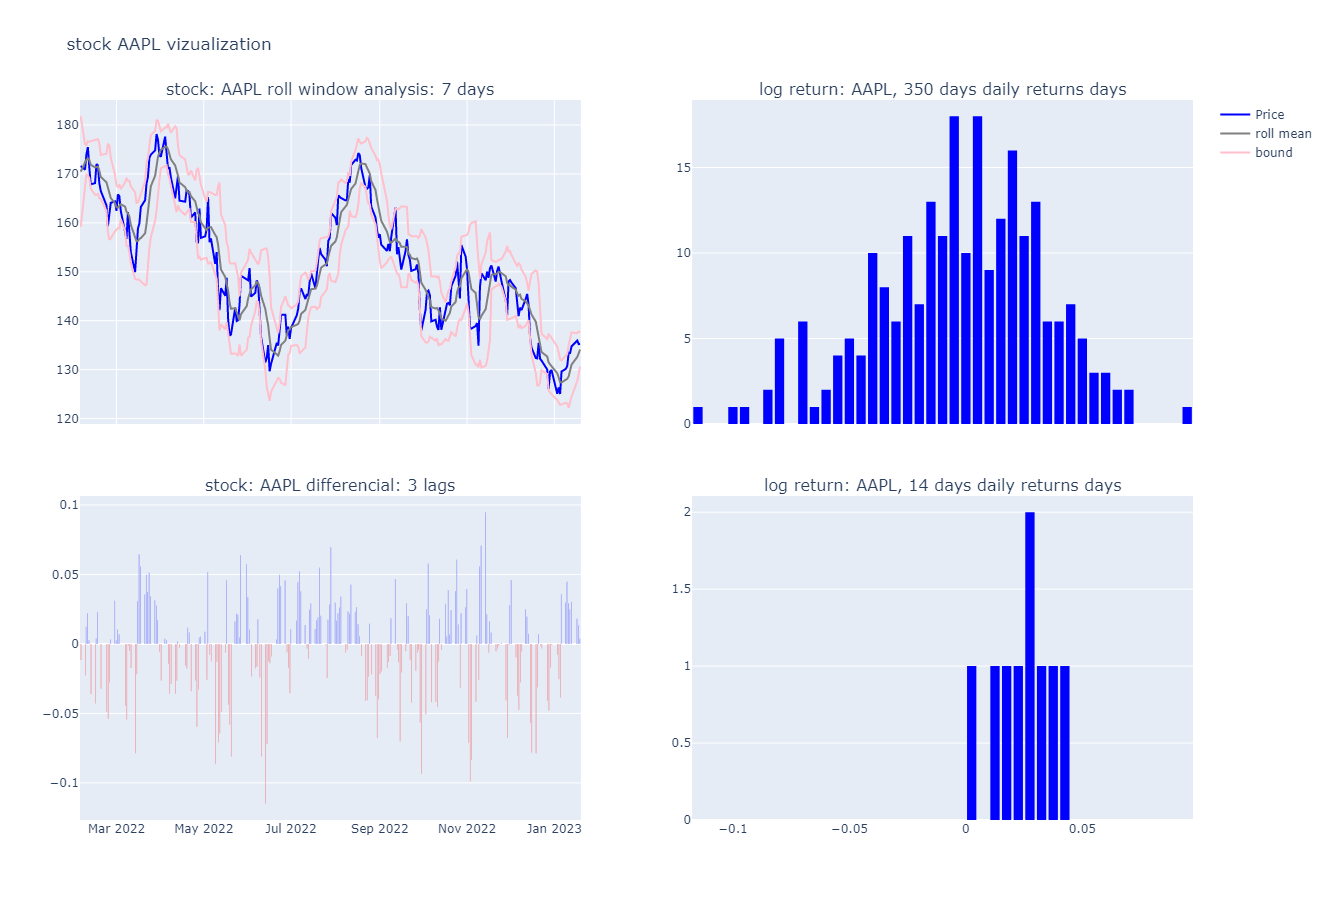

In [30]:
appl_stock = viz_data(stock_code = "AAPL", n_days = n_days, window = window, lags = lags)

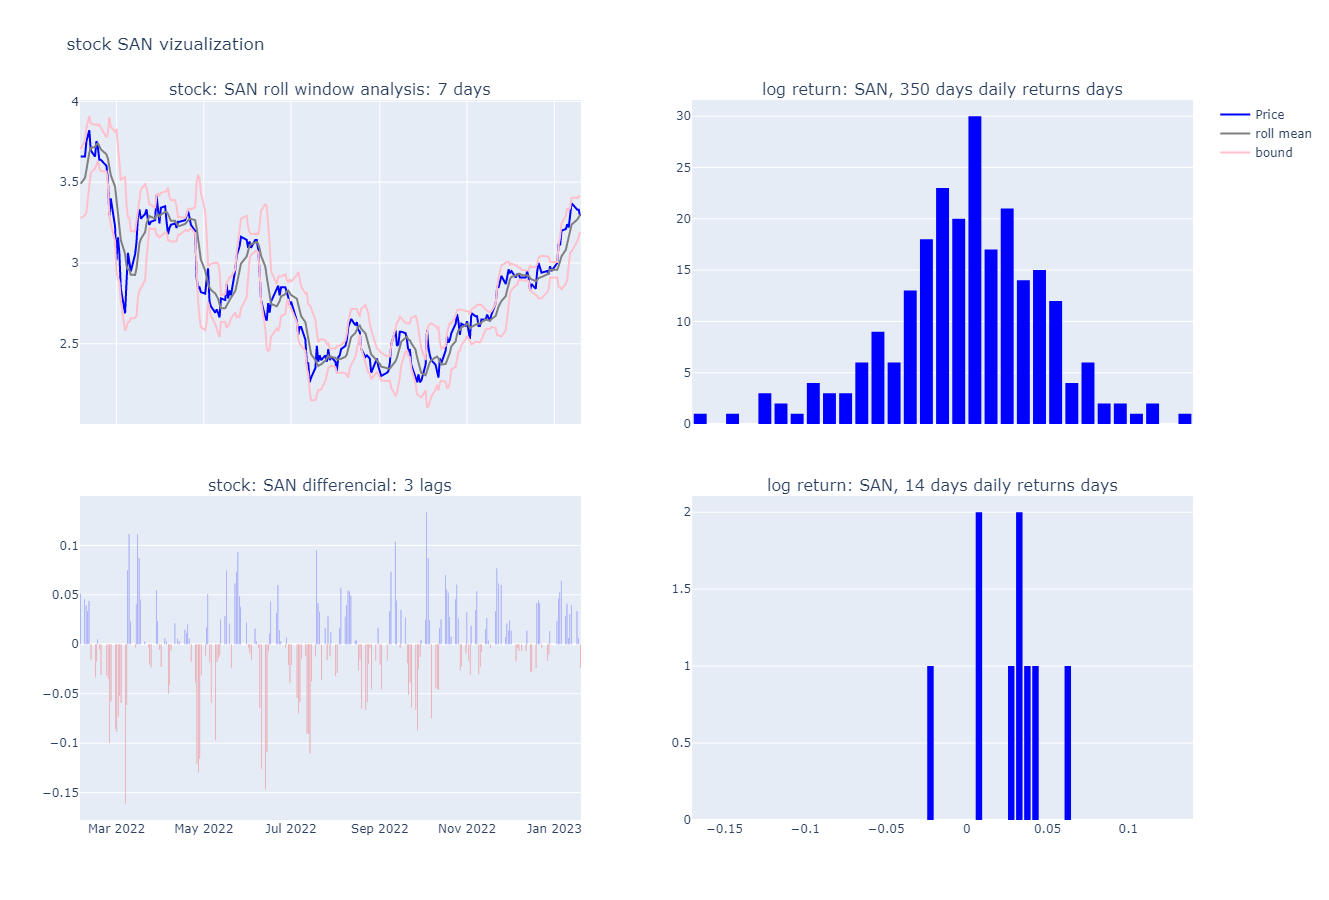

In [31]:
sanof_stock = viz_data(stock_code = "SAN", n_days = n_days, window = window, lags = lags)

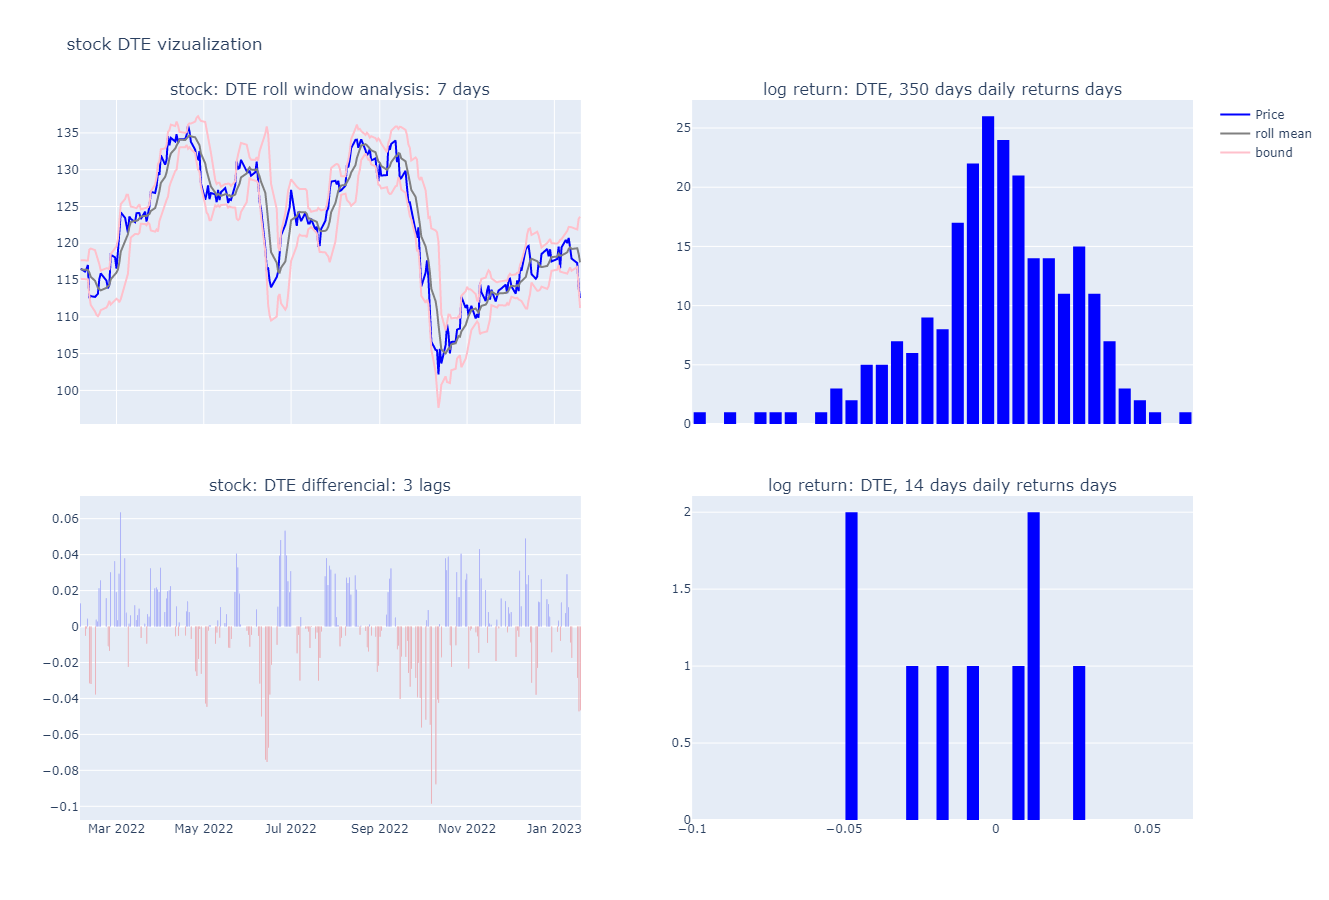

In [32]:
dte_stock = viz_data(stock_code = "DTE", n_days = n_days, window = window, lags = lags)

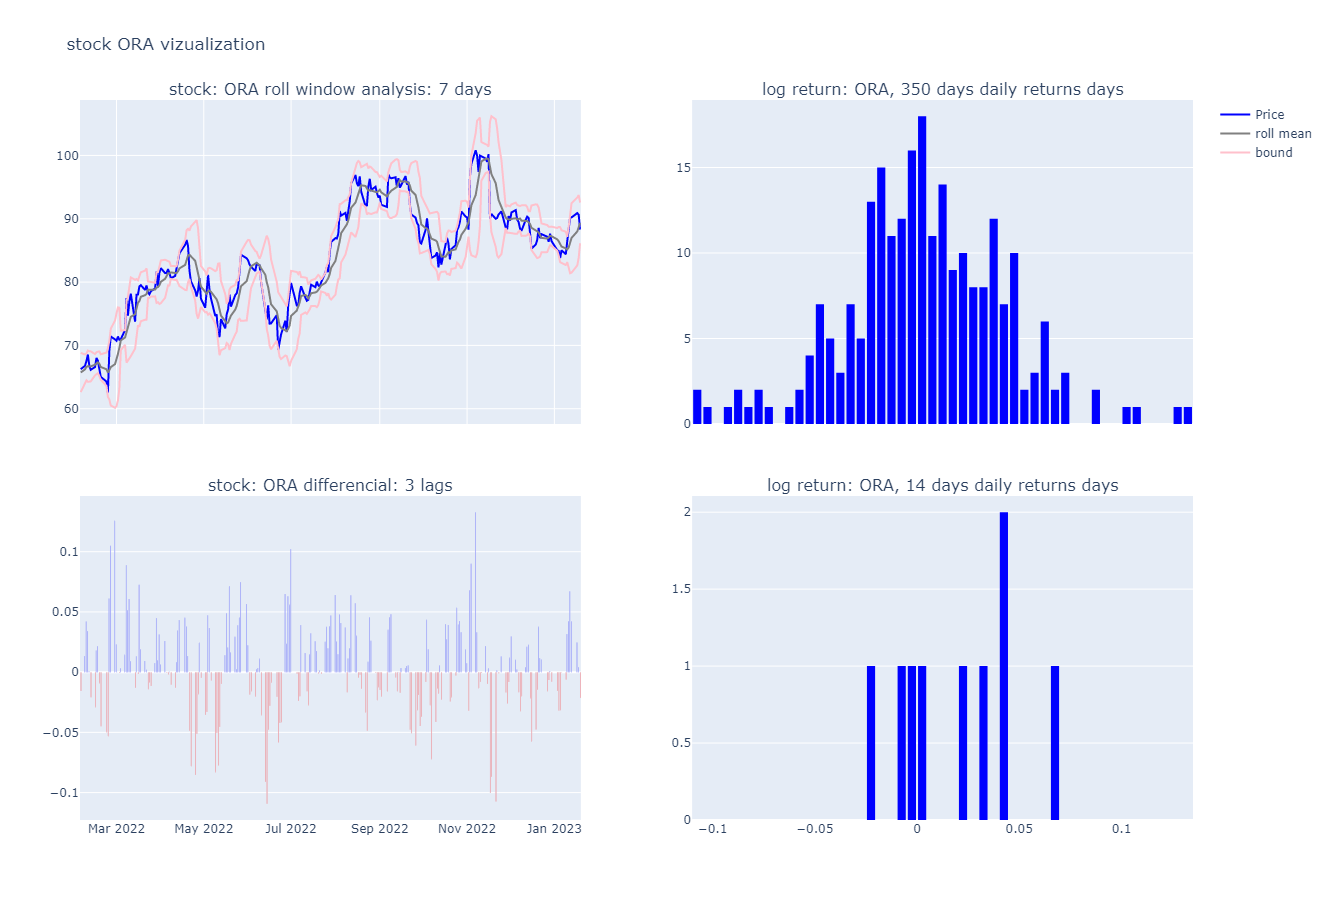

In [33]:
orang_stock = viz_data(stock_code = "ORA", n_days = n_days, window = window, lags = lags)

In [13]:
def shape_data(data, prefix, ref_price, std_column, logdif_column):
    data = data[['Date', ref_price, std_column, logdif_column]]
    data = data.rename(columns = {
        ref_price: f'{prefix}_price',
        std_column: f'{prefix}_stv',
        logdif_column: f'{prefix}_logdif',
    })
    return data

In [14]:
std_column = 'Close_roll_std'
ref_price = 'Close'
logdif_column = 'Dif'

In [15]:
appl_stock = shape_data(appl_stock,'apple', ref_price, std_column, logdif_column)
sanof_stock = shape_data(sanof_stock,'sanof', ref_price, std_column, logdif_column)
dte_stock = shape_data(dte_stock,'dte', ref_price, std_column, logdif_column)
orang_stock = shape_data(orang_stock,'orang', ref_price, std_column, logdif_column)

In [16]:
analysis_dataset = (
    appl_stock
    .merge(sanof_stock, on =['Date'], how = 'outer')
    .merge(dte_stock, on =['Date'], how = 'outer')
    .merge(orang_stock, on =['Date'], how = 'outer')
)

In [17]:
analysis_dataset.head(5)

,Date,apple_price,apple_stv,apple_logdif,sanof_price,sanof_stv,sanof_logdif,dte_price,dte_stv,dte_logdif,orang_price,orang_stv,orang_logdif
0,2022-02-04 00:00:00-05:00,171.613632,5.662431,-0.011522,3.658553,0.106765,0.051155,116.542671,0.635015,0.012748,66.246910,1.550292,-0.015636
1,2022-02-07 00:00:00-05:00,170.886917,1.896536,-0.022785,3.658553,0.115990,0.045645,116.154198,0.643938,-0.005254,66.773865,1.176685,0.013340
2,2022-02-08 00:00:00-05:00,174.042633,1.469190,0.012374,3.754578,0.130120,0.039118,116.474686,0.625178,-0.001083,67.539429,1.063503,0.042092
3,2022-02-09 00:00:00-05:00,175.486099,1.745980,0.022314,3.783385,0.117457,0.033552,117.047684,0.639716,0.004324,68.553574,1.233947,0.034227
4,2022-02-10 00:00:00-05:00,171.344833,1.862616,0.002676,3.821795,0.112648,0.043653,112.541367,1.557188,-0.031598,66.803696,1.209974,0.000447


In [18]:
def data_corr_analysis(data):
    std_columns = [ x for x in data.columns if x.__contains__('_logdif')]
    data = data[ ['Date'] + std_columns]
    data = data.set_index('Date')
    return data

In [19]:
corr_data_base = data_corr_analysis(data = analysis_dataset )

In [20]:
def plot_correlation(data, n_days):
    
    today = datetime.date.today()
    begin_date = today - relativedelta(days = n_days)
    begin_date_str = begin_date.strftime('%Y-%m-%d')
    
    data = data[data.index >= begin_date_str]
    result = data.corr()

    a4_dims = (25.0, 10.0)
    fig, axes = plt.subplots(1,2,figsize=a4_dims)
    sns.heatmap(result , ax = axes[0], annot=True)
    
    begin_date_week = today - relativedelta(days = 7)
    begin_date_week_str = begin_date.strftime('%Y-%m-%d')
    data = data[data.index >= begin_date_week_str]
    result = data.corr()
    sns.heatmap(result , ax = axes[1], annot=True)

    #return result

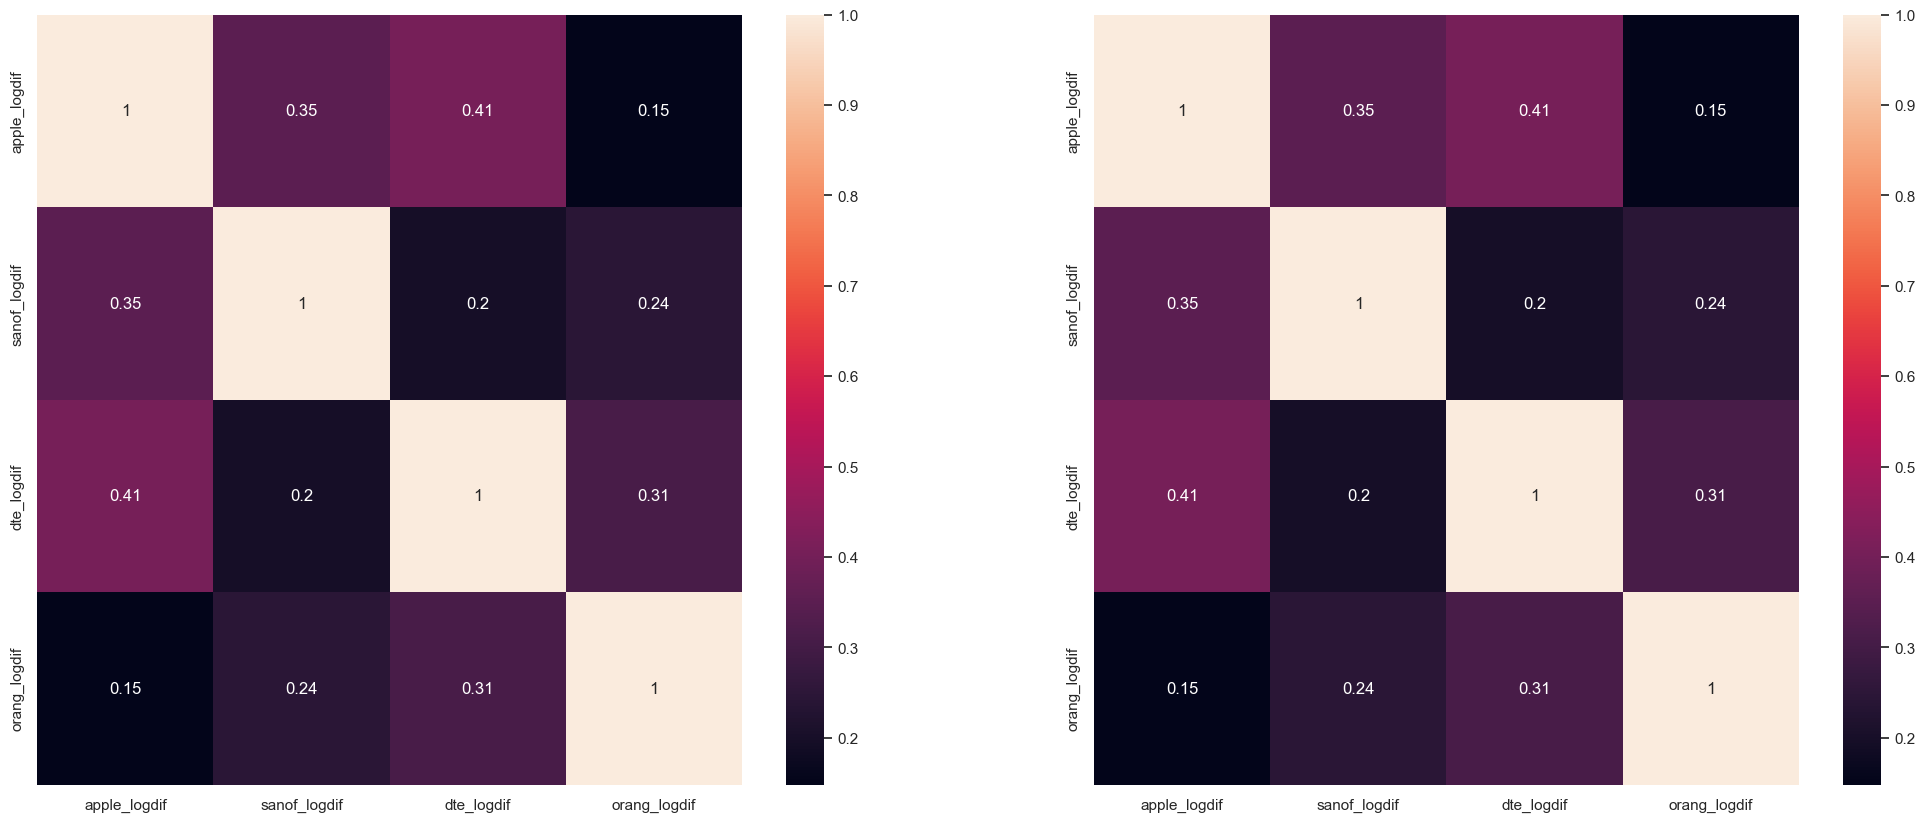

In [21]:
plot_correlation(data = corr_data_base, n_days = 100)